# Digit Recognizer (Best result: 0.99157, Rank 997, Top 36%)

In [1]:
import sys
sys.path.insert(0, '../../Utilities') # https://github.com/LarsNeR/Utilities
from Utilities import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


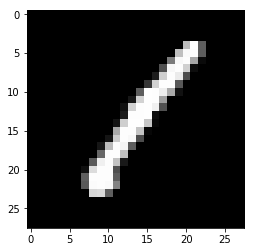

In [4]:
first_image = df_train.iloc[0, 1:].values
first_image = first_image
first_image = np.reshape(first_image, (28,28)).astype(np.uint8)
img = Image.fromarray(first_image, 'L')
plt.imshow(img, cmap='gray')

### Feature Exploration

In [5]:
print(get_sparsely_filled_columns(df_train, threshold=0))
print(get_sparsely_filled_columns(df_test, threshold=0))

Series([], dtype: float64)
Series([], dtype: float64)


No NaNs

## Preprocessing

In [6]:
def preprocess_df(df):
    df = df/255
    return df

## Training

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
df_X = df_train.iloc[:, 1:]
df = preprocess_df(df_X)
X_train = df.values
y_train = df_train.iloc[:, 0].values
kFold = StratifiedKFold(n_splits=10, shuffle=True)

In [8]:
p = {'batch_size': 100,
     'epochs': 3,
     'dropout': 0.3,
     'optimizer': 'rmsprop',
     'losses': 'categorical_crossentropy',
     '1st_kernel_size': (2,2),
     '2nd_kernel_size': (3,3)
    }

### Keras NN

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical

Using TensorFlow backend.


In [10]:
def train_model_nn(X_train, y_train, params, verbose=0):
    clf = Sequential()

    clf.add(Dense(units = X_train.shape[1]*2, activation='relu', input_dim = X_train.shape[1]))
    clf.add(Dropout(float(params['dropout'])))
    
    clf.add(Dense(units = int(X_train.shape[1]*1.5), activation='relu'))
    clf.add(Dropout(float(params['dropout'])))
    
    clf.add(Dense(units = 10, activation='softmax'))

    clf.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    history = clf.fit(X_train, y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']), verbose=verbose)
    return history, clf

In [11]:
def cross_validation_nn(X_train, y_train, params):
    accs = []
    for train, test in kFold.split(X_train, y_train):
        y_ohe = to_categorical(y_train, num_classes=10)
        _, clf = train_model_nn(X_train[train,:], y_ohe[train,:], params, 1)
        y_pred = clf.predict(X_train[test])
        accs.append(accuracy_score(np.argmax(y_pred, axis=1), y_train[test]))
    print(np.mean(accs))
    return train_model_nn(X_train, to_categorical(y_train, num_classes=10), params, 1)

In [12]:
_, clf_nn = cross_validation_nn(X_train, y_train, p)

Epoch 1/3
37794/37794 [==============================] - 35s 914us/step - loss: 0.2741 - acc: 0.9178
Epoch 2/3
37794/37794 [==============================] - 34s 892us/step - loss: 0.1194 - acc: 0.9639
Epoch 3/3
37794/37794 [==============================] - 34s 901us/step - loss: 0.0926 - acc: 0.9734
Epoch 1/3
37796/37796 [==============================] - 38s 1000us/step - loss: 0.2698 - acc: 0.9160
Epoch 2/3
37796/37796 [==============================] - 38s 1ms/step - loss: 0.1189 - acc: 0.9656
Epoch 3/3
37796/37796 [==============================] - 35s 928us/step - loss: 0.0945 - acc: 0.9734
Epoch 1/3
37798/37798 [==============================] - 35s 927us/step - loss: 0.2755 - acc: 0.9155
Epoch 2/3
37798/37798 [==============================] - 35s 918us/step - loss: 0.1228 - acc: 0.9639
Epoch 3/3
37798/37798 [==============================] - 35s 916us/step - loss: 0.0943 - acc: 0.9726
Epoch 1/3
37799/37799 [==============================] - 35s 920us/step - loss: 0.2724 - acc

Accuracy of around 97%

### Keras CNN 1D

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Dropout
from keras.utils import to_categorical

In [14]:
def train_model_cnn(X_train, y_train, params, verbose=0):
    clf = Sequential()
    
    clf.add(Conv1D(56, 3, activation='relu', input_shape=(X_train.shape[1],1)))
    clf.add(Conv1D(56, 3, activation='relu'))
    clf.add(MaxPooling1D(3))
    
    clf.add(Conv1D(112, 3, activation='relu'))
    clf.add(Conv1D(112, 3, activation='relu'))
    clf.add(GlobalAveragePooling1D())
    
    clf.add(Dropout(float(params['dropout'])))
    
    clf.add(Dense(units = 10, activation='softmax'))    

    clf.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    history = clf.fit(X_train, y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']), verbose=verbose)
    return history, clf

In [15]:
def cross_validation_cnn(X_train, y_train, params):
    accs = []
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    for train, test in kFold.split(X_train, y_train):
        y_ohe = to_categorical(y_train, num_classes=10)
        _, clf = train_model_cnn(X_train[train,:], y_ohe[train,:], params, 1)
        y_pred = clf.predict(X_train[test])
        accs.append(accuracy_score(np.argmax(y_pred, axis=1), y_train[test]))
    print(np.mean(accs))
    return train_model_cnn(X_train, to_categorical(y_train, num_classes=10), params, 1)

In [16]:
_, clf_cnn = cross_validation_cnn(X_train, y_train, p)

Epoch 1/3
37794/37794 [==============================] - 233s 6ms/step - loss: 2.0488 - acc: 0.2485
Epoch 2/3
37794/37794 [==============================] - 233s 6ms/step - loss: 1.6686 - acc: 0.3976
Epoch 3/3
37794/37794 [==============================] - 216s 6ms/step - loss: 1.4929 - acc: 0.4714
Epoch 1/3
37796/37796 [==============================] - 207s 5ms/step - loss: 2.0176 - acc: 0.2600
Epoch 2/3
37796/37796 [==============================] - 208s 6ms/step - loss: 1.6322 - acc: 0.4107
Epoch 3/3
37796/37796 [==============================] - 207s 5ms/step - loss: 1.4630 - acc: 0.4876
Epoch 1/3
37798/37798 [==============================] - 208s 6ms/step - loss: 2.0490 - acc: 0.2497
Epoch 2/3
37798/37798 [==============================] - 206s 5ms/step - loss: 1.6901 - acc: 0.3868
Epoch 3/3
37798/37798 [==============================] - 207s 5ms/step - loss: 1.5079 - acc: 0.4650
Epoch 1/3
37799/37799 [==============================] - 209s 6ms/step - loss: 2.0419 - acc: 0.2509


Accuracy of around 50% 

### Keras CNN 2D

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.layers import Dropout
from keras.utils import to_categorical

def train_model_cnn2d(X_train, y_train, X_val, y_val, params, verbose=0):
    clf = Sequential()

    clf.add(Conv2D(filters = 32, kernel_size = params['1st_kernel_size'], activation ='relu', input_shape = (28,28,1)))
    clf.add(Conv2D(filters = 32, kernel_size = params['1st_kernel_size'], activation ='relu'))
    clf.add(MaxPool2D(pool_size=(2,2)))
    clf.add(Dropout(float(params['dropout'])))

    clf.add(Conv2D(filters = 64, kernel_size = params['2nd_kernel_size'], activation ='relu'))
    clf.add(Conv2D(filters = 64, kernel_size = params['2nd_kernel_size'], activation ='relu'))
    clf.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    clf.add(Dropout(float(params['dropout'])))

    clf.add(Flatten())
    clf.add(Dense(256, activation = "relu"))
    clf.add(Dropout(float(params['dropout'])))
    clf.add(Dense(10, activation = "softmax"))
    
    clf.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=["accuracy"])
    history = clf.fit(X_train, y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']), verbose=verbose)
    return history, clf

def cross_validation_cnn2d(X_train, y_train, params):
    accs = []
    X_train = np.reshape(X_train, (-1, 28, 28, 1))
    for train, test in kFold.split(X_train, y_train):
        y_ohe = to_categorical(y_train, num_classes=10)
        _, clf = train_model_cnn2d(X_train[train,:], y_ohe[train,:], None, None, params, 1)
        y_pred = clf.predict(X_train[test])
        accs.append(accuracy_score(np.argmax(y_pred, axis=1), y_train[test]))
    print(np.mean(accs))
    return train_model_cnn2d(X_train, to_categorical(y_train, num_classes=10), None, None, params, 1)

In [13]:
_, clf_cnn2d = cross_validation_cnn2d(X_train, y_train, p)

Epoch 1/3
37794/37794 [==============================] - 126s 3ms/step - loss: 0.2706 - acc: 0.9119
Epoch 2/3
37794/37794 [==============================] - 109s 3ms/step - loss: 0.0799 - acc: 0.9751
Epoch 3/3
37794/37794 [==============================] - 140s 4ms/step - loss: 0.0591 - acc: 0.9815
Epoch 1/3
37796/37796 [==============================] - 138s 4ms/step - loss: 0.2754 - acc: 0.9117
Epoch 2/3
37796/37796 [==============================] - 138s 4ms/step - loss: 0.0883 - acc: 0.9729
Epoch 3/3
37796/37796 [==============================] - 127s 3ms/step - loss: 0.0641 - acc: 0.9801
Epoch 1/3
37798/37798 [==============================] - 121s 3ms/step - loss: 0.2769 - acc: 0.9116
Epoch 2/3
37798/37798 [==============================] - 127s 3ms/step - loss: 0.0871 - acc: 0.9737
Epoch 3/3
37798/37798 [==============================] - 134s 4ms/step - loss: 0.0603 - acc: 0.9811
Epoch 1/3
37799/37799 [==============================] - 139s 4ms/step - loss: 0.2767 - acc: 0.9119


Accuracy of around 98%

## Predicting

Train all 3 models on whole dataset and then convert it to kaggle submission csv

In [ ]:
df_test = pd.read_csv('./data/test.csv')
df_result = pd.DataFrame({'ImageId': np.arange(1, df_test.shape[0]+1)})
df = preprocess_df(df_test)
X_test = df.values

df_result['Label'] = np.argmax(clf_nn.predict(X_test), axis=1)
df_result.to_csv('./data/result_nn.csv', index=False)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
df_result['Label'] = np.argmax(clf_cnn.predict(X_test), axis=1)
df_result.to_csv('./data/result_cnn.csv', index=False)

X_test = np.reshape(X_test, (-1, 28, 28, 1))
df_result['Label'] = np.argmax(clf_cnn2d.predict(X_test), axis=1)
df_result.to_csv('./data/result_cnn2d.csv', index=False)

#### Submitting them to Kaggle gave following results
- NN: 0.9660 (Rank 2161)
- CNN: 0.5862 (Rank ?)
- CNN-2D: 0.9874 (Rank 1326)

### Hyperparameter-Tuning

CNN-2D gave best results so I'm trying to improve it with hyperparameter-tuning. I'm trying talos with some downsampling because the runs take quite long.

In [ ]:
import talos as ta

In [ ]:
p = {'batch_size': [50],
     'epochs': [4],
     'dropout': [0.1, 0.3, 0.5, 0.7],
     'optimizer': ['rmsprop', 'nadam'],
     'losses': ['categorical_crossentropy'],
     '1st_kernel_size': [(2,2), (3,3)],
     '2nd_kernel_size': [(3,3), (4,4)]
    }

In [ ]:
X_train = np.reshape(X_train, (-1, 28, 28, 1))
y_ohe = to_categorical(y_train, num_classes=10)
h = ta.Scan(X_train, y_ohe,
          params=p,
          dataset_name='Digit Recognizer',
          experiment_no='1',
          model=train_model_cnn2d,
          grid_downsample=0.5)

In [ ]:
ta.Reporting(t).data

Best parameters:

{'dropout': 0.1, 'optimizer': 'rmsprop', '1st_kernel_size': (3,3), '2nd_kernel_size': (4,4)}

Accuracy: 0.9907139


## Final run of CNN-2D with these parameters

In [ ]:
p = {'batch_size': 50,
     'epochs': 6,
     'dropout': 0.1,
     'optimizer': 'rmsprop',
     'losses': 'categorical_crossentropy',
     '1st_kernel_size': (3,3),
     '2nd_kernel_size': (4,4)
    }
X_train = np.reshape(X_train, (-1, 28, 28, 1))
y_ohe = to_categorical(y_train, num_classes=10)
_, clf_final = train_model_cnn2d(X_train, y_ohe,_, _, p,verbose=1)

In [ ]:
df_test = pd.read_csv('./data/test.csv')
df_result = pd.DataFrame({'ImageId': np.arange(1, df_test.shape[0]+1)})
df = preprocess_df(df_test)
X_test = df.values
X_test = np.reshape(X_test, (-1, 28, 28, 1))
df_result['Label'] = np.argmax(clf_final.predict(X_test), axis=1)
df_result.to_csv('./data/result_final.csv', index=False)

Gives a result of 0.99157 (Rank 997)

## Notes/What can improve the model
- Augmentation of new images
- More epochs, lower batch_size
- Different network structure

## Final Python Code

You can find the final python code in src/Main.py